In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nc_files = sorted( glob.glob( r"C:\Users\locfa_v05v5qi\Documents\escadas_termohalinas\raw\Dataset\**\*.nc", recursive=True ) )

In [3]:
def subset_region(ds):
    # Ajustar longitudes se estiverem em 0–360
    if ds.lon.max() > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    # Criar máscara apenas para a dimensão n (perfis)
    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -50) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds
    
def check_staircase_exists(ml_h, gl_h): #verifica se os valores são fisicamente válidos (n só se existem)

    valid_ml = np.sum(~np.isnan(ml_h) & (ml_h > 0))
    valid_gl = np.sum(~np.isnan(gl_h) & (gl_h > 0))

    return (valid_ml >= 1) and (valid_gl >= 1)
    
def detect_staircases(ds):

    profile_dim = ds.lat.dims[0]
    n_profiles = ds.sizes[profile_dim] #p n ter problema d confundir "n" e "Nobs"

    staircase_sf = np.zeros(n_profiles, dtype=bool)
    staircase_dc = np.zeros(n_profiles, dtype=bool)

    for i in range(n_profiles):

        # =========================
        # SALT FINGER
        # =========================
        ml_mask_sf = ds.mask_ml_sf_layer.isel({profile_dim: i}) > 0
        gl_mask_sf = ds.mask_gl_sf_layer.isel({profile_dim: i}) > 0

        ml_h_sf = ds.ml_h.isel({profile_dim: i}).values[ml_mask_sf.values] #pega os valores onde ml_mask_sf é True 
        gl_h_sf = ds.gl_h.isel({profile_dim: i}).values[gl_mask_sf.values]

        if len(ml_h_sf) > 0 and len(gl_h_sf) > 0:
            staircase_sf[i] = check_staircase_exists(
                ml_h_sf, gl_h_sf
            )

        # =========================
        # DIFFUSIVE CONVECTION
        # =========================
        ml_mask_dc = ds.mask_ml_dc_layer.isel({profile_dim: i}) > 0
        gl_mask_dc = ds.mask_gl_dc_layer.isel({profile_dim: i}) > 0

        ml_h_dc = ds.ml_h.isel({profile_dim: i}).values[ml_mask_dc.values]
        gl_h_dc = ds.gl_h.isel({profile_dim: i}).values[gl_mask_dc.values]

        if len(ml_h_dc) > 0 and len(gl_h_dc) > 0:
            staircase_dc[i] = check_staircase_exists(
                ml_h_dc, gl_h_dc
            )

    ds["staircase_sf"] = (profile_dim, staircase_sf)
    ds["staircase_dc"] = (profile_dim, staircase_dc)

    return ds

In [21]:
# Listas acumuladoras
ml_data = []
gl_data = []
n_perfis = 0

for file in nc_files:

    ds = xr.open_dataset(file)
    # 1) Recorte regional
    ds = subset_region(ds)

    if ds.sizes.get("Nobs", 0) == 0:
        continue

    # 2) Detectar staircases
    ds = detect_staircases(ds)
    n_profiles = ds.sizes["Nobs"]

    for i in range(n_profiles):

        lat = ds.lat.values[i]
        # --- SF ---
        mask_sf = ds.mask_ml_sf_layer.values[i, :]
        idx_sf = np.where(mask_sf > 0)[0]

        for j in idx_sf:
            ml_data.append({
                "regime": "SF",
                "depth": ds.ml_p.values[i, j], #(dbar)
                "thickness": ds.ml_h.values[i, j],
                "lat": lat
            })
        if len(idx_sf) > 0 or len(idx_dc) > 0:
            n_perfis += 1
            
        # --- DC ---
        mask_dc = ds.mask_ml_dc_layer.values[i, :]
        idx_dc = np.where(mask_dc > 0)[0]

        for j in idx_dc:
            ml_data.append({
                "regime": "DC",
                "depth": ds.ml_p.values[i, j],
                "thickness": ds.ml_h.values[i, j],
                "lat": lat
            })

        # GRADIENT LAYERS
        # --- SF ---
        mask_sf_gl = ds.mask_gl_sf_layer.values[i, :]
        idx_sf_gl = np.where(mask_sf_gl > 0)[0]

        for j in idx_sf_gl:
            gl_data.append({
                "regime": "SF",
                "dT": ds.gl_dT.values[i, j],
                "dS": ds.gl_dS.values[i, j]
            })

        # --- DC ---
        mask_dc_gl = ds.mask_gl_dc_layer.values[i, :]
        idx_dc_gl = np.where(mask_dc_gl > 0)[0]

        for j in idx_dc_gl:
            gl_data.append({
                "regime": "DC",
                "dT": ds.gl_dT.values[i, j],
                "dS": ds.gl_dS.values[i, j]
            })

    ds.close()

# =====================================
# Criar DataFrames
# =====================================

df_ml = pd.DataFrame(ml_data)
df_gl = pd.DataFrame(gl_data)

# Remover possíveis NaNs
df_ml = df_ml.dropna()
df_gl = df_gl.dropna()

# Criar bins

df_ml["depth_bin"] = pd.cut(
    df_ml["depth"],
    bins=[0, 500, 1000, 1500, 2000],
    labels=["0-500", "500-1000", "1000-1500", "1500-2000"]
)

df_ml["lat_bin"] = pd.cut(
    df_ml["lat"],
    bins=np.arange(-60, 10, 10)
)

sns.set(style="whitegrid")

In [22]:
print(n_perfis)

17511


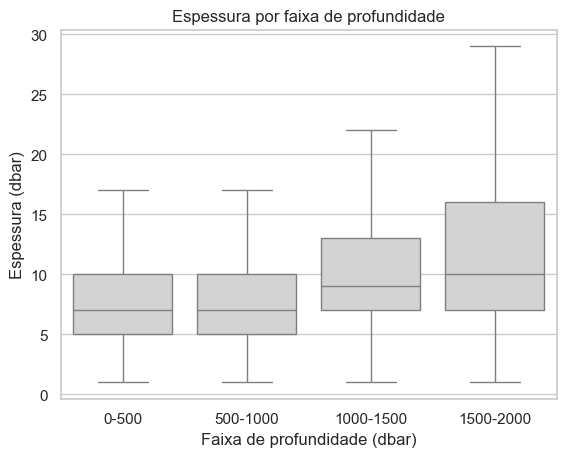

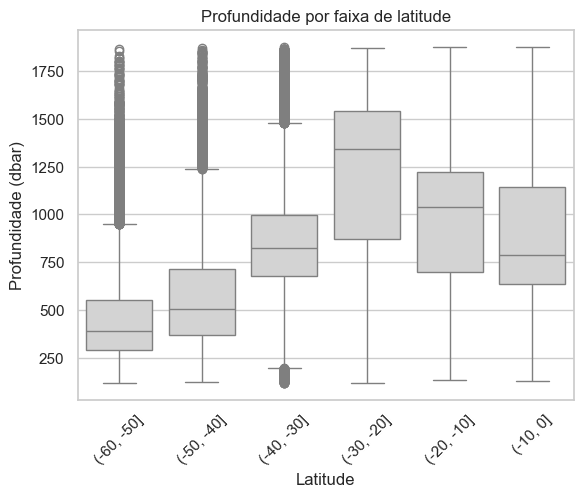

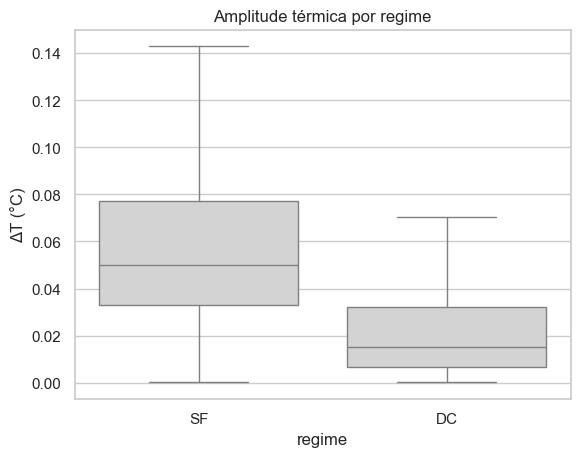

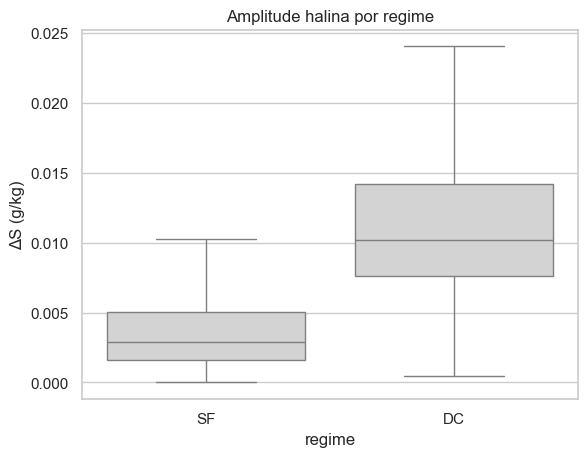

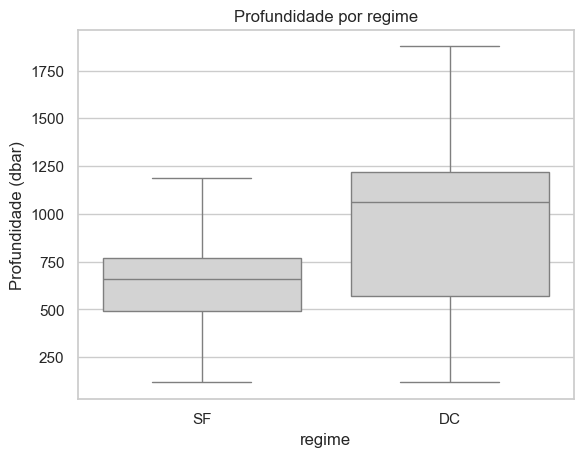

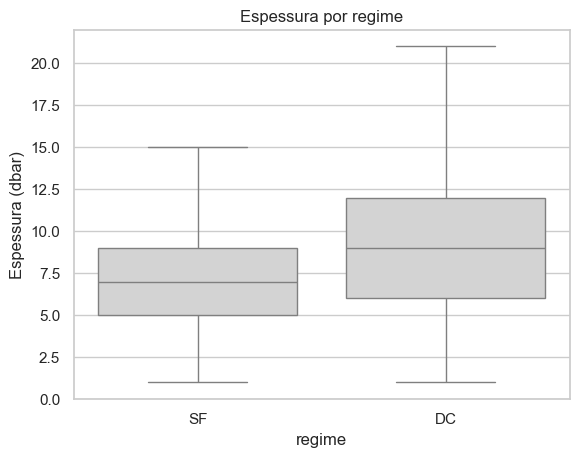

In [26]:
#Espessura × profundidade

plt.figure()
sns.boxplot(data=df_ml, x="depth_bin", y="thickness", color="lightgrey", showfliers=False)
plt.title("Espessura por faixa de profundidade")
plt.xlabel("Faixa de profundidade (dbar)")
plt.ylabel("Espessura (dbar)")
plt.show()

#Profundidade × latitude

plt.figure()
sns.boxplot(data=df_ml, x="lat_bin", y="depth", color="lightgrey")
plt.xticks(rotation=45)
plt.title("Profundidade por faixa de latitude")
plt.xlabel("Latitude")
plt.ylabel("Profundidade (dbar)")
plt.show()

#Amplitude térmica × regime

plt.figure()
sns.boxplot(data=df_gl, x="regime", y="dT", color="lightgrey", showfliers=False)
plt.title("Amplitude térmica por regime")
plt.ylabel("ΔT (°C)")
plt.show()

#Amplitude halina × regime

plt.figure()
sns.boxplot(data=df_gl, x="regime", y="dS", color="lightgrey", showfliers=False)
plt.title("Amplitude halina por regime")
plt.ylabel("ΔS (g/kg)")
plt.show()

#Profundidade × regime

plt.figure()
sns.boxplot(data=df_ml, x="regime", y="depth", color="lightgrey", showfliers=False)
plt.title("Profundidade por regime")
plt.ylabel("Profundidade (dbar)")
plt.show()

#Espessura × regime

plt.figure()
sns.boxplot(data=df_ml, x="regime", y="thickness", color="lightgrey", showfliers=False)
plt.title("Espessura por regime")
plt.ylabel("Espessura (dbar)")
plt.show()